# Experiment 3: WikiArt Inference with Classifier-Free Guidance

This notebook explores the trained WikiArt text-to-image model, demonstrating:
- Generation across all 27 art styles
- Effect of different guidance scales
- Comparison with real WikiArt images
- Multiple samples per style to show diversity
- Custom prompt variations

## 1. Setup and Configuration

In [1]:
# Project configuration - use absolute paths
from pathlib import Path
import sys

PROJECT_ROOT = Path("/home/doshlom4/work/final_project")
sys.path.insert(0, str(PROJECT_ROOT))

print(f"Project root: {PROJECT_ROOT}")

Project root: /home/doshlom4/work/final_project


In [2]:
# Set HuggingFace cache directories to project dataset_cache (before any HuggingFace imports)
import os
os.environ['HF_HOME'] = str(PROJECT_ROOT / "dataset_cache" / "huggingface")
os.environ['TRANSFORMERS_CACHE'] = str(PROJECT_ROOT / "dataset_cache" / "huggingface" / "transformers")
os.environ['HF_DATASETS_CACHE'] = str(PROJECT_ROOT / "dataset_cache")
print("="*70)
print("HuggingFace Cache Configuration")
print("="*70)
print(f"HF_HOME: {os.environ['HF_HOME']}")
print(f"TRANSFORMERS_CACHE: {os.environ['TRANSFORMERS_CACHE']}")
print(f"HF_DATASETS_CACHE: {os.environ['HF_DATASETS_CACHE']}")
print("="*70)

HuggingFace Cache Configuration
HF_HOME: /home/doshlom4/work/final_project/dataset_cache/huggingface
TRANSFORMERS_CACHE: /home/doshlom4/work/final_project/dataset_cache/huggingface/transformers
HF_DATASETS_CACHE: /home/doshlom4/work/final_project/dataset_cache


In [3]:
# Device configuration
# Set to False if you encounter CUDA out of memory errors (common in shared GPU environments)
USE_GPU = True  # Set to False to force CPU usage

print(f"GPU enabled: {USE_GPU}")
if not USE_GPU:
    print("⚠️  Running on CPU - inference will be slower but more stable")

GPU enabled: False
⚠️  Running on CPU - inference will be slower but more stable


In [4]:
# Import configuration
from config import (
    EXPERIMENT_3_CONFIG,
    INFERENCE_CONFIG,
    TOKENIZER_MAX_LENGTH,
    CLIP_MODEL_NAME,
    WIKIART_STYLES,
    DATASET_CACHE_DIR,
    get_latest_wikiart_unet_checkpoint,
    get_wikiart_unet_checkpoint_path,
)

# Deep learning frameworks
import torch
from diffusers import DDPMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from tqdm import tqdm

# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# HuggingFace datasets
from datasets import load_dataset
import torchvision.transforms as transforms

print("Libraries imported successfully")

/home/doshlom4/work/conda/envs/shlomid_conda_12_11_2025/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/doshlom4/work/conda/envs/shlomid_conda_12_11_2025/lib/python3.10/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Libraries imported successfully


In [5]:
# Print configuration
print("WikiArt Configuration:")
print(f"  Number of styles: {len(WIKIART_STYLES)}")
print(f"  Inference steps: {INFERENCE_CONFIG['num_inference_steps']}")
print(f"  Prompt template: {EXPERIMENT_3_CONFIG['prompt_template']}")
print()
print("Art Styles:")
for i, style in enumerate(WIKIART_STYLES):
    print(f"  {i:2d}: {style}")

WikiArt Configuration:
  Number of styles: 27
  Inference steps: 50
  Prompt template: A painting in the style of {style_name}

Art Styles:
   0: Abstract_Expressionism
   1: Action_painting
   2: Analytical_Cubism
   3: Art_Nouveau_Modern
   4: Baroque
   5: Color_Field_Painting
   6: Contemporary_Realism
   7: Cubism
   8: Early_Renaissance
   9: Expressionism
  10: Fauvism
  11: High_Renaissance
  12: Impressionism
  13: Mannerism_Late_Renaissance
  14: Minimalism
  15: Naive_Art_Primitivism
  16: New_Realism
  17: Northern_Renaissance
  18: Pointillism
  19: Pop_Art
  20: Post_Impressionism
  21: Realism
  22: Rococo
  23: Romanticism
  24: Symbolism
  25: Synthetic_Cubism
  26: Ukiyo_e


## 2. Load Models

In [6]:
# Set up device based on configuration
if USE_GPU and torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using device: {device}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    device = torch.device("cpu")
    print(f"Using device: {device}")
    if not USE_GPU:
        print("GPU disabled by configuration (USE_GPU=False)")
    elif not torch.cuda.is_available():
        print("⚠️  CUDA not available, falling back to CPU")
    print("⚠️  Note: CPU inference will be significantly slower")

Using device: cpu
GPU disabled by configuration (USE_GPU=False)
⚠️  Note: CPU inference will be significantly slower


In [7]:
# List all checkpoints for WikiArt UNet, sorted by epoch
from config import list_wikiart_unet_checkpoints

checkpoints = list_wikiart_unet_checkpoints()
print(f"Found {len(checkpoints)} WikiArt UNet checkpoints:")
for ckpt in checkpoints:
    # Extract epoch from filename
    try:
        epoch = int(str(ckpt).split("_")[-1].split(".")[0])
    except Exception:
        epoch = "?"
    print(f"  Epoch {epoch:>3}: {ckpt.name}")

Found 12 WikiArt UNet checkpoints:
  Epoch   0: wikiart_unet_checkpoint_epoch_0.pt
  Epoch   5: wikiart_unet_checkpoint_epoch_5.pt
  Epoch   9: wikiart_unet_checkpoint_epoch_9.pt
  Epoch  19: wikiart_unet_checkpoint_epoch_19.pt
  Epoch  29: wikiart_unet_checkpoint_epoch_29.pt
  Epoch  39: wikiart_unet_checkpoint_epoch_39.pt
  Epoch  49: wikiart_unet_checkpoint_epoch_49.pt
  Epoch  59: wikiart_unet_checkpoint_epoch_59.pt
  Epoch  69: wikiart_unet_checkpoint_epoch_69.pt
  Epoch  79: wikiart_unet_checkpoint_epoch_79.pt
  Epoch  89: wikiart_unet_checkpoint_epoch_89.pt
  Epoch  99: wikiart_unet_checkpoint_epoch_99.pt


In [8]:
# Load trained UNet model from checkpoint
from models.custom_unet_wikiart import CustomUNet2DConditionModelWikiArt

# Get latest checkpoint
checkpoint_path = get_latest_wikiart_unet_checkpoint()
print(f"Loading checkpoint: {checkpoint_path}")

# First, inspect the checkpoint structure
checkpoint = torch.load(str(checkpoint_path), map_location=device)
print(f"\nCheckpoint keys: {list(checkpoint.keys())}")

# Load model with proper key handling
unet = CustomUNet2DConditionModelWikiArt().to(device)

# Handle different checkpoint formats
if "unet_state_dict" in checkpoint:
    unet.load_state_dict(checkpoint["unet_state_dict"])
elif "model_state_dict" in checkpoint:
    unet.load_state_dict(checkpoint["model_state_dict"])
elif "state_dict" in checkpoint:
    unet.load_state_dict(checkpoint["state_dict"])
else:
    # Assume the checkpoint is the state dict itself
    unet.load_state_dict(checkpoint)

unet.eval()

epoch = checkpoint.get('epoch', 'unknown') if isinstance(checkpoint, dict) else 'unknown'
print(f"\n✓ Loaded WikiArt UNet from epoch {epoch}")
print(f"  Parameters: {unet.get_num_parameters():,}")

Loading checkpoint: /home/doshlom4/work/final_project/checkpoints/wikiart_unet_checkpoint_epoch_99.pt

Checkpoint keys: ['conv_in.weight', 'conv_in.bias', 'time_embedding.linear_1.weight', 'time_embedding.linear_1.bias', 'time_embedding.linear_2.weight', 'time_embedding.linear_2.bias', 'down_blocks.0.resnets.0.norm1.weight', 'down_blocks.0.resnets.0.norm1.bias', 'down_blocks.0.resnets.0.conv1.weight', 'down_blocks.0.resnets.0.conv1.bias', 'down_blocks.0.resnets.0.time_emb_proj.weight', 'down_blocks.0.resnets.0.time_emb_proj.bias', 'down_blocks.0.resnets.0.norm2.weight', 'down_blocks.0.resnets.0.norm2.bias', 'down_blocks.0.resnets.0.conv2.weight', 'down_blocks.0.resnets.0.conv2.bias', 'down_blocks.0.resnets.1.norm1.weight', 'down_blocks.0.resnets.1.norm1.bias', 'down_blocks.0.resnets.1.conv1.weight', 'down_blocks.0.resnets.1.conv1.bias', 'down_blocks.0.resnets.1.time_emb_proj.weight', 'down_blocks.0.resnets.1.time_emb_proj.bias', 'down_blocks.0.resnets.1.norm2.weight', 'down_blocks.0.re

In [9]:
import time

t0 = time.time()
print("Loading text encoder...")
text_encoder = CLIPTextModel.from_pretrained(CLIP_MODEL_NAME)
print("Loaded model in", time.time() - t0, "sec")

t1 = time.time()
print("Moving to device...")
text_encoder = text_encoder.to(device)
print("Moved to device in", time.time() - t1, "sec")

t2 = time.time()
print("Loading tokenizer...")
tokenizer = CLIPTokenizer.from_pretrained(CLIP_MODEL_NAME)
print("Tokenizer loaded in", time.time() - t2, "sec")


Loading text encoder...
Loaded model in 1.5736417770385742 sec
Moving to device...
Moved to device in 0.004148006439208984 sec
Loading tokenizer...
Tokenizer loaded in 0.5408589839935303 sec


In [10]:
import os
print('TRANSFORMERS_CACHE:', os.environ.get('TRANSFORMERS_CACHE'))
print('HF_HOME:', os.environ.get('HF_HOME'))
print('Default HuggingFace cache:', os.path.expanduser('~/.cache/huggingface'))
print('Listing ~/.cache/huggingface/transformers:')
import glob
for f in glob.glob(os.path.expanduser('~/.cache/huggingface/transformers/*')):
    print('  ', f)

TRANSFORMERS_CACHE: /home/doshlom4/work/final_project/dataset_cache/huggingface/transformers
HF_HOME: /home/doshlom4/work/final_project/dataset_cache/huggingface
Default HuggingFace cache: /home/doshlom4/.cache/huggingface
Listing ~/.cache/huggingface/transformers:


## 3. Generation Functions

In [11]:
@torch.no_grad()
def generate_images(
    prompts: list[str],
    guidance_scale: float = 7.5,
    num_inference_steps: int = 50,
    show_progress: bool = True
) -> torch.Tensor:
    """
    Generate WikiArt images using classifier-free guidance.
    
    Args:
        prompts: List of text prompts
        guidance_scale: CFG scale (0 = unconditional, higher = more conditioned)
        num_inference_steps: Number of denoising steps
        show_progress: Whether to show progress bar
    
    Returns:
        Tensor of images (B, 3, 128, 128) in [0, 1] range
    """
    batch_size = len(prompts)
    
    # Encode text prompts
    text_input = tokenizer(
        prompts,
        padding="max_length",
        max_length=TOKENIZER_MAX_LENGTH,
        truncation=True,
        return_tensors="pt"
    )
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]
    
    # Unconditional embeddings for CFG
    uncond_input = tokenizer(
        [""] * batch_size,
        padding="max_length",
        max_length=TOKENIZER_MAX_LENGTH,
        return_tensors="pt"
    )
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]
    
    # Concatenate for CFG
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
    
    # Initialize noise
    latents = torch.randn((batch_size, 3, 128, 128), device=device)
    
    # Setup scheduler
    scheduler = DDPMScheduler(
        beta_schedule=INFERENCE_CONFIG["beta_schedule"],
        num_train_timesteps=INFERENCE_CONFIG["num_train_timesteps"]
    )
    scheduler.set_timesteps(num_inference_steps)
    
    # Denoising loop
    timesteps = tqdm(scheduler.timesteps, desc="Generating") if show_progress else scheduler.timesteps
    
    for t in timesteps:
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)
        
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
        
        # CFG
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        
        latents = scheduler.step(noise_pred, t, latents).prev_sample
    
    # Denormalize from [-1, 1] to [0, 1]
    images = (latents / 2 + 0.5).clamp(0, 1)
    
    return images


def tensor_to_pil(tensor: torch.Tensor) -> Image.Image:
    """Convert tensor (C, H, W) in [0, 1] to PIL Image."""
    array = (tensor.cpu().numpy() * 255).astype(np.uint8)
    array = np.transpose(array, (1, 2, 0))  # CHW -> HWC
    return Image.fromarray(array)


print("Generation functions defined")

Generation functions defined


## 4. Generate All Art Styles

Generate one sample for each of the 27 art styles.

In [12]:
# Generate one image per style
guidance_scale = 7.5
generated_images = {}

print(f"Generating images for all {len(WIKIART_STYLES)} art styles (guidance_scale={guidance_scale})...\n")

for style_idx, style_name in enumerate(WIKIART_STYLES):
    style_display = style_name.replace('_', ' ')
    prompt = EXPERIMENT_3_CONFIG["prompt_template"].format(style_name=style_display)
    
    images = generate_images([prompt], guidance_scale=guidance_scale, show_progress=True)
    generated_images[style_name] = images[0]
    
    print(f"  [{style_idx+1:2d}/{len(WIKIART_STYLES)}] {style_display}")

print("\nGeneration complete!")

Generating images for all 27 art styles (guidance_scale=7.5)...



Generating: 100%|██████████| 50/50 [00:34<00:00,  1.43it/s]


  [ 1/27] Abstract Expressionism


Generating: 100%|██████████| 50/50 [00:35<00:00,  1.42it/s]


  [ 2/27] Action painting


Generating: 100%|██████████| 50/50 [00:35<00:00,  1.42it/s]


  [ 3/27] Analytical Cubism


Generating: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


  [ 4/27] Art Nouveau Modern


Generating: 100%|██████████| 50/50 [00:35<00:00,  1.41it/s]


  [ 5/27] Baroque


Generating: 100%|██████████| 50/50 [00:35<00:00,  1.41it/s]


  [ 6/27] Color Field Painting


Generating: 100%|██████████| 50/50 [00:35<00:00,  1.41it/s]


  [ 7/27] Contemporary Realism


Generating: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


  [ 8/27] Cubism


Generating: 100%|██████████| 50/50 [00:35<00:00,  1.41it/s]


  [ 9/27] Early Renaissance


Generating: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


  [10/27] Expressionism


Generating: 100%|██████████| 50/50 [00:35<00:00,  1.41it/s]


  [11/27] Fauvism


Generating: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


  [12/27] High Renaissance


Generating: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


  [13/27] Impressionism


Generating: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


  [14/27] Mannerism Late Renaissance


Generating: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


  [15/27] Minimalism


Generating: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


  [16/27] Naive Art Primitivism


Generating: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


  [17/27] New Realism


Generating: 100%|██████████| 50/50 [00:36<00:00,  1.38it/s]


  [18/27] Northern Renaissance


Generating: 100%|██████████| 50/50 [00:36<00:00,  1.38it/s]


  [19/27] Pointillism


Generating: 100%|██████████| 50/50 [00:36<00:00,  1.38it/s]


  [20/27] Pop Art


Generating: 100%|██████████| 50/50 [00:36<00:00,  1.38it/s]


  [21/27] Post Impressionism


Generating: 100%|██████████| 50/50 [00:36<00:00,  1.38it/s]


  [22/27] Realism


Generating: 100%|██████████| 50/50 [00:36<00:00,  1.38it/s]


  [23/27] Rococo


Generating: 100%|██████████| 50/50 [00:36<00:00,  1.39it/s]


  [24/27] Romanticism


Generating: 100%|██████████| 50/50 [00:36<00:00,  1.38it/s]


  [25/27] Symbolism


Generating: 100%|██████████| 50/50 [00:36<00:00,  1.38it/s]


  [26/27] Synthetic Cubism


Generating: 100%|██████████| 50/50 [00:36<00:00,  1.38it/s]

  [27/27] Ukiyo e

Generation complete!


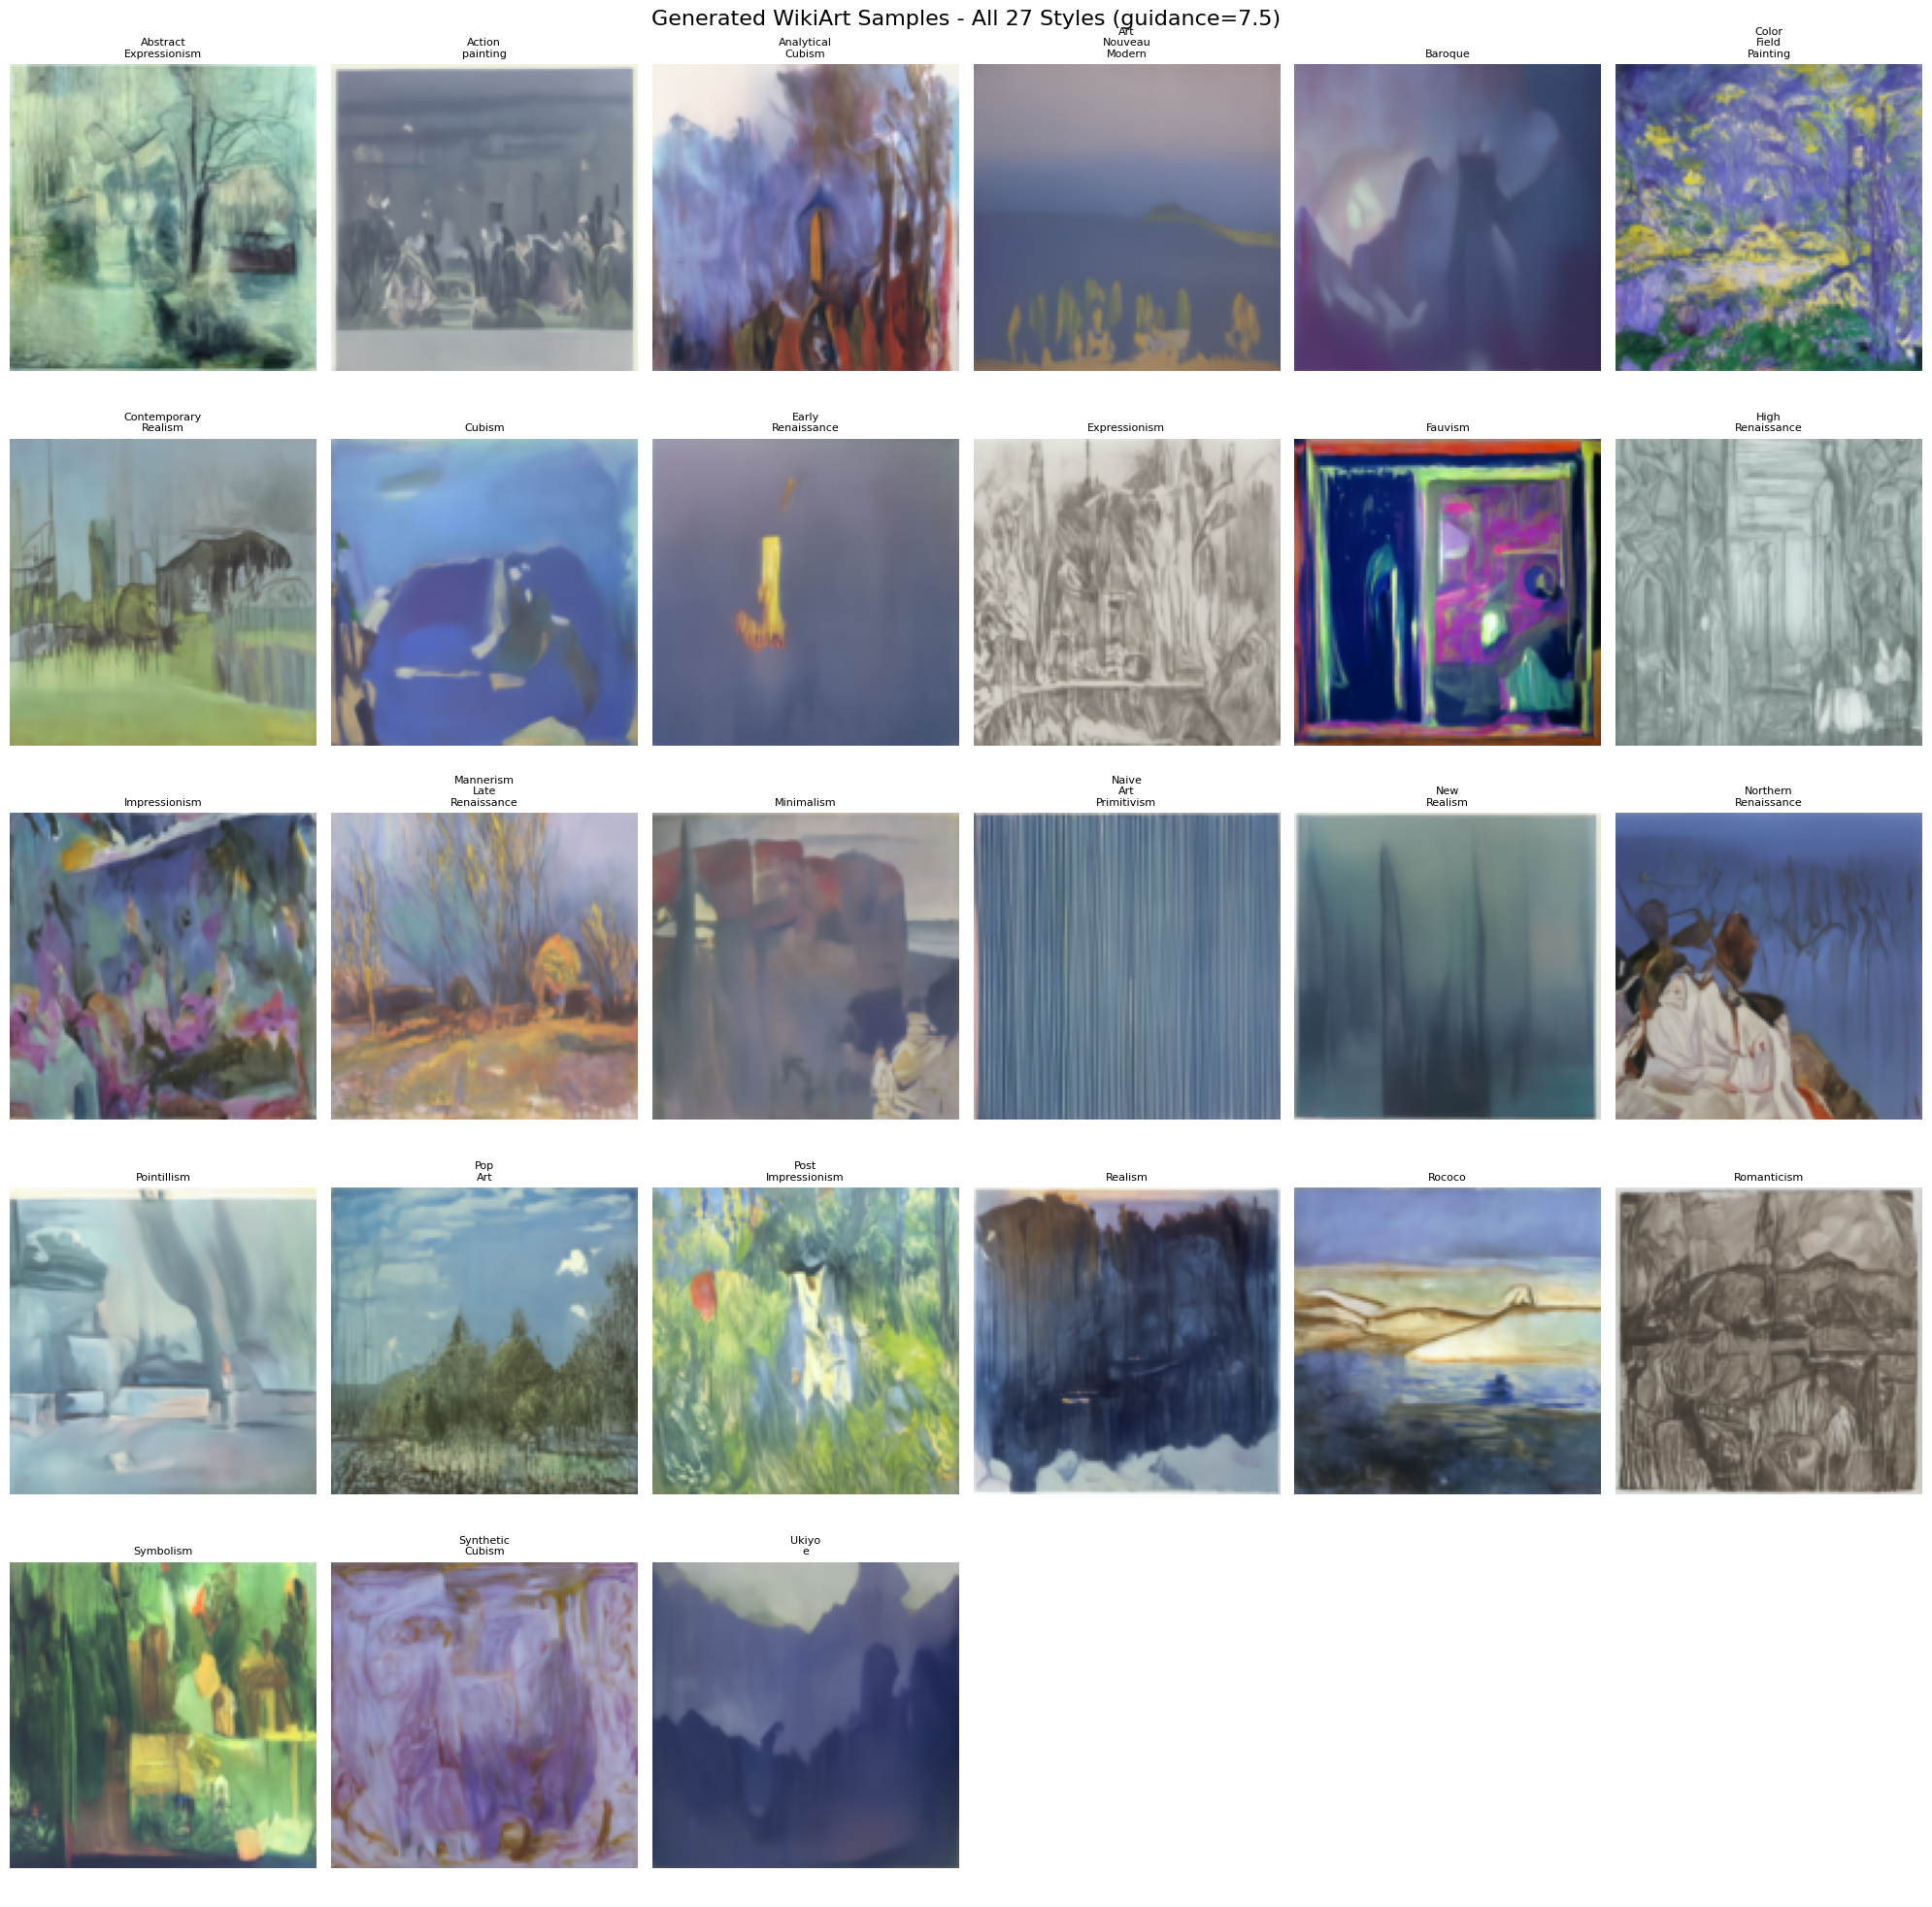

In [13]:
# Display all generated styles in a grid
n_cols = 6
n_rows = (len(WIKIART_STYLES) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

for i, (style_name, img_tensor) in enumerate(generated_images.items()):
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    axes[i].imshow(img)
    axes[i].set_title(style_name.replace('_', '\n'), fontsize=8)
    axes[i].axis('off')

# Hide empty subplots
for i in range(len(WIKIART_STYLES), len(axes)):
    axes[i].axis('off')

plt.suptitle(f'Generated WikiArt Samples - All 27 Styles (guidance={guidance_scale})', fontsize=16)
plt.tight_layout()
plt.show()

## 5. Compare with Real WikiArt Images

In [14]:
# Load WikiArt dataset for comparison
print("Loading WikiArt dataset for comparison...")
wikiart_hf = load_dataset(
    "huggan/wikiart",
    split="train",
    cache_dir=str(DATASET_CACHE_DIR / "huggingface")
)

print(f"Loaded {len(wikiart_hf)} images")

Loading WikiArt dataset for comparison...
Loaded 81444 images


In [ ]:
# Get sample index for style column
sample = wikiart_hf[0]
style_column = 'style' if 'style' in sample else 'label'
print(f"Style column: {style_column}")

# Get one real image per style
real_images_per_style = {}

for item in wikiart_hf:
    style_idx = item[style_column]
    if style_idx < len(WIKIART_STYLES):
        style_name = WIKIART_STYLES[style_idx]
        if style_name not in real_images_per_style:
            real_images_per_style[style_name] = item['image']
    
    # Stop when we have all styles
    if len(real_images_per_style) == len(WIKIART_STYLES):
        break

print(f"Found real images for {len(real_images_per_style)} styles")

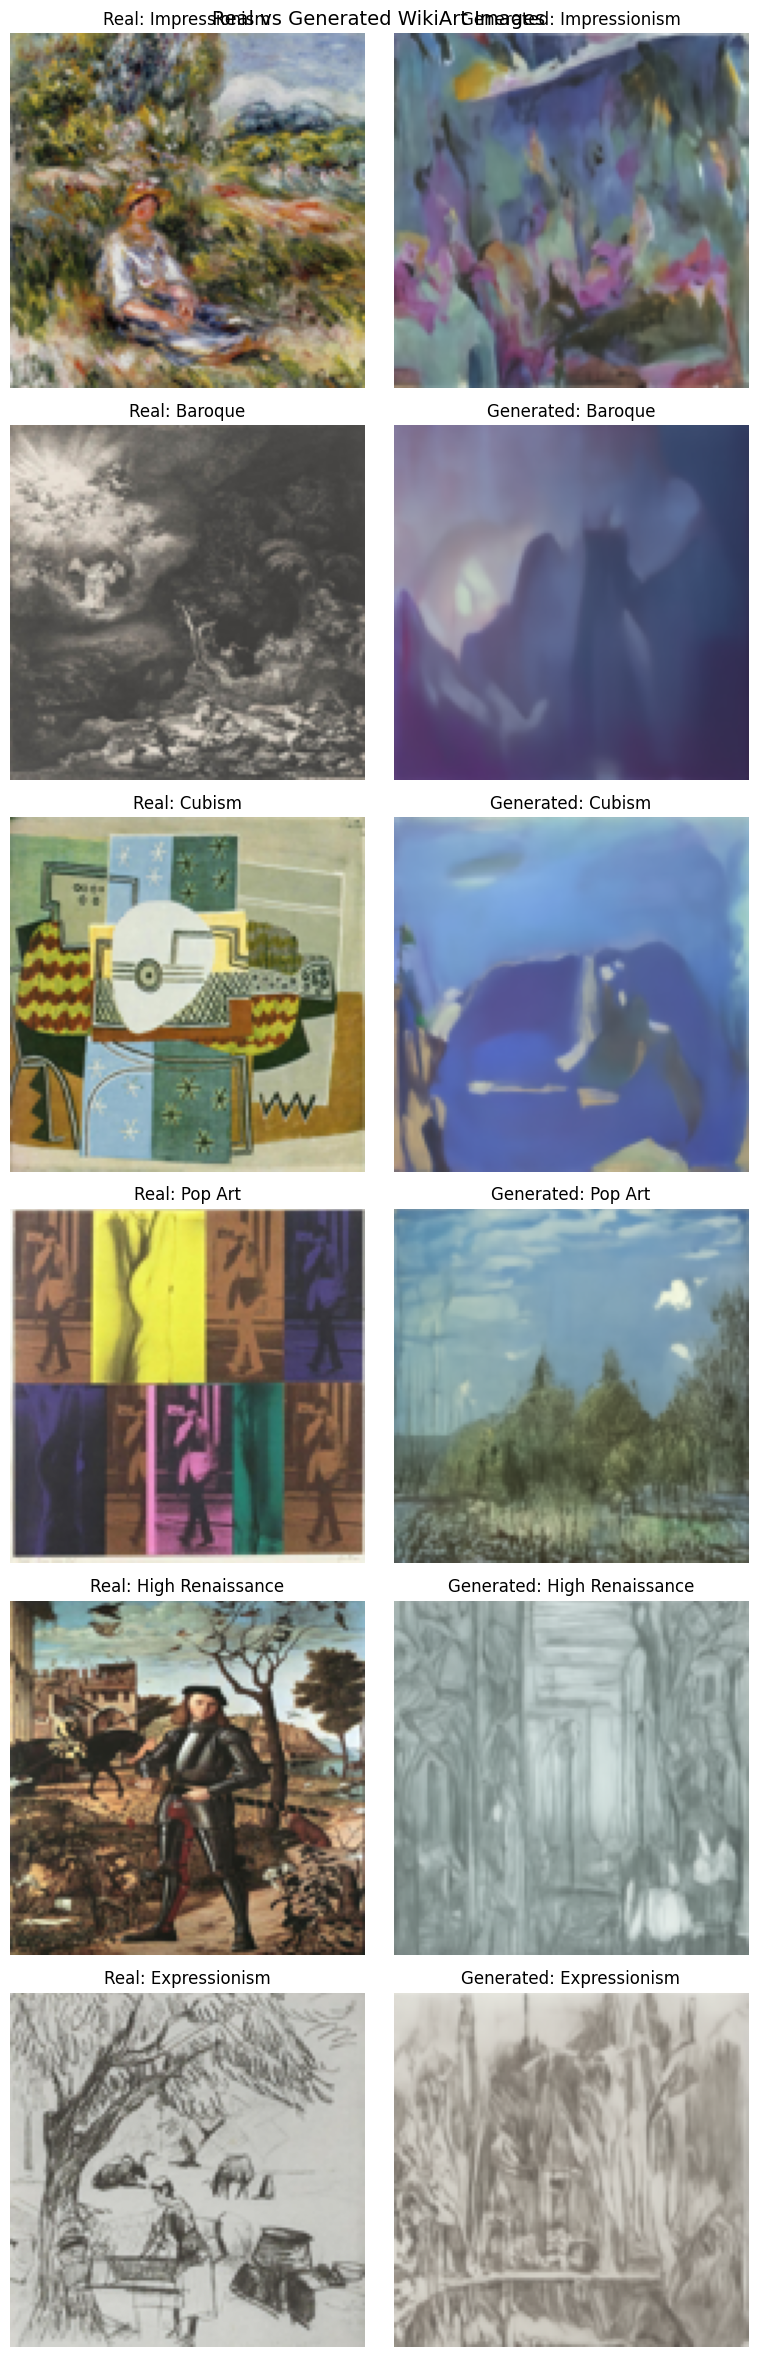

In [16]:
# Side-by-side comparison: Real vs Generated
selected_styles = [
    "Impressionism", "Baroque", "Cubism", "Pop_Art",
    "Renaissance" if "Renaissance" in WIKIART_STYLES else "High_Renaissance",
    "Expressionism"
]
# Filter to available styles
selected_styles = [s for s in selected_styles if s in generated_images]

fig, axes = plt.subplots(len(selected_styles), 2, figsize=(8, 4 * len(selected_styles)))

for i, style_name in enumerate(selected_styles):
    # Real image
    if style_name in real_images_per_style:
        real_img = real_images_per_style[style_name]
        if real_img.mode != 'RGB':
            real_img = real_img.convert('RGB')
        real_img_resized = real_img.resize((128, 128))
        axes[i, 0].imshow(real_img_resized)
    else:
        axes[i, 0].text(0.5, 0.5, 'N/A', ha='center', va='center')
    axes[i, 0].set_title(f'Real: {style_name.replace("_", " ")}')
    axes[i, 0].axis('off')
    
    # Generated image
    gen_img = generated_images[style_name].permute(1, 2, 0).cpu().numpy()
    axes[i, 1].imshow(gen_img)
    axes[i, 1].set_title(f'Generated: {style_name.replace("_", " ")}')
    axes[i, 1].axis('off')

plt.suptitle('Real vs Generated WikiArt Images', fontsize=14)
plt.tight_layout()
plt.show()

## 6. Guidance Scale Ablation

Explore the effect of different guidance scales on generation quality.

In [ ]:
# Test different guidance scales
test_styles = ["Impressionism", "Pop_Art", "Baroque"]
guidance_scales = [0, 2, 5, 7.5, 10, 15, 20]

fig, axes = plt.subplots(len(test_styles), len(guidance_scales), 
                          figsize=(3 * len(guidance_scales), 3 * len(test_styles)))

for row, style_name in enumerate(test_styles):
    style_display = style_name.replace('_', ' ')
    prompt = EXPERIMENT_3_CONFIG["prompt_template"].format(style_name=style_display)
    
    for col, guidance_scale in enumerate(guidance_scales):
        images = generate_images([prompt], guidance_scale=guidance_scale, show_progress=False)
        img = images[0].permute(1, 2, 0).cpu().numpy()
        
        axes[row, col].imshow(img)
        if row == 0:
            axes[row, col].set_title(f'w={guidance_scale}')
        if col == 0:
            axes[row, col].set_ylabel(style_display, fontsize=10)
        axes[row, col].set_xticks([])
        axes[row, col].set_yticks([])

plt.suptitle('Effect of Guidance Scale on WikiArt Generation', fontsize=14)
plt.tight_layout()
plt.show()

## 7. Multiple Samples Per Style

Show diversity in generation for the same style.

In [ ]:
# Generate multiple samples for a few styles
diversity_styles = ["Impressionism", "Cubism", "Pop_Art"]
num_samples = 5
guidance_scale = 7.5

fig, axes = plt.subplots(len(diversity_styles), num_samples, 
                          figsize=(3 * num_samples, 3 * len(diversity_styles)))

for row, style_name in enumerate(diversity_styles):
    style_display = style_name.replace('_', ' ')
    prompt = EXPERIMENT_3_CONFIG["prompt_template"].format(style_name=style_display)
    
    for col in range(num_samples):
        images = generate_images([prompt], guidance_scale=guidance_scale, show_progress=False)
        img = images[0].permute(1, 2, 0).cpu().numpy()
        
        axes[row, col].imshow(img)
        axes[row, col].axis('off')
        if col == 0:
            axes[row, col].set_title(style_display, fontsize=10, loc='left')

plt.suptitle(f'Generation Diversity (guidance={guidance_scale})', fontsize=14)
plt.tight_layout()
plt.show()

## 8. Inference Steps Ablation

Effect of number of denoising steps on quality.

In [ ]:
# Test different numbers of inference steps
test_style = "Impressionism"
inference_steps_list = [10, 20, 30, 50, 75, 100]
guidance_scale = 7.5

style_display = test_style.replace('_', ' ')
prompt = EXPERIMENT_3_CONFIG["prompt_template"].format(style_name=style_display)

fig, axes = plt.subplots(1, len(inference_steps_list), figsize=(3 * len(inference_steps_list), 3))

for i, num_steps in enumerate(inference_steps_list):
    images = generate_images([prompt], guidance_scale=guidance_scale, 
                             num_inference_steps=num_steps, show_progress=False)
    img = images[0].permute(1, 2, 0).cpu().numpy()
    
    axes[i].imshow(img)
    axes[i].set_title(f'{num_steps} steps')
    axes[i].axis('off')

plt.suptitle(f'Effect of Inference Steps on "{style_display}" (guidance={guidance_scale})', fontsize=14)
plt.tight_layout()
plt.show()

## 9. Custom Prompt Variations

Test the model with different prompt formulations.

In [ ]:
# Test different prompt formulations
base_style = "Impressionism"
prompt_variations = [
    f"A painting in the style of {base_style}",
    f"An {base_style} painting",
    f"A landscape in {base_style} style",
    f"A portrait in the {base_style} movement",
    f"{base_style} artwork",
    f"Beautiful {base_style} painting",
]

guidance_scale = 7.5

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, prompt in enumerate(prompt_variations):
    images = generate_images([prompt], guidance_scale=guidance_scale, show_progress=False)
    img = images[0].permute(1, 2, 0).cpu().numpy()
    
    axes[i].imshow(img)
    axes[i].set_title(f'"{prompt}"', fontsize=8, wrap=True)
    axes[i].axis('off')

plt.suptitle('Prompt Variations for Same Style', fontsize=14)
plt.tight_layout()
plt.show()

## 10. Unconditional Generation

Generate images without any text conditioning (guidance_scale = 0).

In [ ]:
# Unconditional generation (no text guidance)
num_unconditional = 6

fig, axes = plt.subplots(1, num_unconditional, figsize=(3 * num_unconditional, 3))

for i in range(num_unconditional):
    # Empty prompt with guidance_scale = 0 (pure unconditional)
    images = generate_images(["A painting"], guidance_scale=0, show_progress=False)
    img = images[0].permute(1, 2, 0).cpu().numpy()
    
    axes[i].imshow(img)
    axes[i].set_title(f'Sample {i+1}')
    axes[i].axis('off')

plt.suptitle('Unconditional WikiArt Generation (guidance_scale=0)', fontsize=14)
plt.tight_layout()
plt.show()

## Summary

This notebook explored the trained WikiArt text-to-image model:

**Demonstrations:**
1. Generated samples for all 27 art styles
2. Compared generated images with real WikiArt images
3. Showed effect of guidance scale (0 to 20)
4. Demonstrated generation diversity for same style
5. Tested different numbers of inference steps
6. Explored prompt variations
7. Showed unconditional generation

**Next steps:**
- `generate_images.ipynb` - Bulk generation for evaluation
- `train2_train_wikiart_classifier.ipynb` - Train art style classifier
- `metrics1_evaluate_wikiart.ipynb` - Compute FID and classification metrics

## Inference: Prompt × Guidance Scale × Diversity
This cell demonstrates the effect of guidance scale and sampling diversity for a single prompt.
- **Prompt:** You can edit the prompt in the code cell below.
- **Guidance scales:** 0, 2, 5, 10, 15, 20, 30 (rows)
- **Samples:** 5 images per guidance scale (columns)
- Each row shows how the same prompt is rendered with a different guidance scale.
- Each column shows a different random sample for the same prompt and guidance scale.

In [ ]:
# Inference: Single prompt, multiple images, varying guidance scales
prompt = "A painting in the style of Impressionism"  # You can change this prompt
guidance_scales = [0, 2, 5, 10, 15, 20, 30]
num_samples = 5
fig, axes = plt.subplots(len(guidance_scales), num_samples, figsize=(3*num_samples, 3*len(guidance_scales)))
for row, guidance_scale in enumerate(guidance_scales):
    for col in range(num_samples):
        images = generate_images([prompt], guidance_scale=guidance_scale, show_progress=True)
        img = images[0].permute(1, 2, 0).cpu().numpy()
        axes[row, col].imshow(img)
        axes[row, col].axis('off')
        if col == 0:
            axes[row, col].set_ylabel(f"w={guidance_scale}", fontsize=10)
        if row == 0:
            axes[row, col].set_title(f"Sample {col+1}")
plt.suptitle(f'Prompt: "{prompt}"\nGuidance scale and sample diversity', fontsize=14)
plt.tight_layout()
plt.show()

## Inference: Same Experiment with 200 Inference Steps

This cell repeats the previous experiment but with **200 inference steps** (vs 50 default).
- **Purpose:** Compare quality improvement with more denoising steps
- **Same random seed:** Results are directly comparable to the previous cell
- **Trade-off:** 4x slower generation time but potentially higher quality
- **Guidance scales:** 0, 2, 5, 10, 15, 20, 30 (rows)
- **Samples:** 5 images per guidance scale (columns)

In [ ]:
# Inference: Same prompt and seed, but with 200 inference steps
prompt = "A painting in the style of Impressionism"  # Same prompt as above
guidance_scales = [0, 2, 5, 10, 15, 20, 30]
num_samples = 5
num_inference_steps = 200  # Increased from default 50

fig, axes = plt.subplots(len(guidance_scales), num_samples, figsize=(3*num_samples, 3*len(guidance_scales)))

# Set seed for reproducibility and comparison with previous cell
torch.manual_seed(42)
np.random.seed(42)

for row, guidance_scale in enumerate(guidance_scales):
    for col in range(num_samples):
        # Use same seed for each (row, col) position to match previous experiment
        torch.manual_seed(42 + row * num_samples + col)
        
        images = generate_images(
            [prompt], 
            guidance_scale=guidance_scale, 
            num_inference_steps=num_inference_steps,
            show_progress=True
        )
        img = images[0].permute(1, 2, 0).cpu().numpy()
        axes[row, col].imshow(img)
        axes[row, col].axis('off')
        if col == 0:
            axes[row, col].set_ylabel(f"w={guidance_scale}", fontsize=10)
        if row == 0:
            axes[row, col].set_title(f"Sample {col+1}")

plt.suptitle(f'Prompt: "{prompt}"\n200 Inference Steps (vs 50 default)', fontsize=14)
plt.tight_layout()
plt.show()

print(f"\n⏱️  Note: 200 steps took ~4x longer than 50 steps")
print(f"Compare the quality difference between this and the previous cell!")